In [1]:
import numpy as np
import os
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


In [3]:
# Hàm này duyệt qua các thư mục trong directory, mỗi thư mục con tương ứng với một nhãn (label).
def load_images_from_directory(directory, image_size=(128, 128)):
    images = []
    labels = []
    valid_extensions = ['.jpg', '.jpeg', '.png']  # Supported image formats

    for label in os.listdir(directory):
        label_folder = os.path.join(directory, label)
        if os.path.isdir(label_folder):
            for img_name in os.listdir(label_folder):
                img_path = os.path.join(label_folder, img_name)
                if os.path.isfile(img_path) and img_name != '.DS_Store' and any(img_name.endswith(ext) for ext in valid_extensions):
                    try:
                        image = Image.open(img_path).convert('RGB').resize(image_size)
                        image = np.array(image).flatten()  # Flatten the image to a 1D vector
                        images.append(image)
                        labels.append(label)
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
    # Chuẩn hóa dữ liệu hình ảnh
    images = np.array(images) / 255.0  # Normalize image data to the range [0, 1]
    return images, np.array(labels)


In [5]:
# Lấy dữ liệu
print("Loading images...")
X, y = load_images_from_directory('data/test')  # Thay bằng đường dẫn thư mục của bạn
print(f"Loaded {len(X)} images")

# Chia dữ liệu thành bộ huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {len(X_train)} images")
print(f"Testing set: {len(X_test)} images")

Loading images...
Loaded 1000 images
Training set: 800 images
Testing set: 200 images


In [7]:
# Lớp KNN
class KNN:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for x in X:
            distances = [np.linalg.norm(x - x_train) for x_train in self.X_train]
            k_nearest_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_nearest_indices]
            values, counts = np.unique(k_nearest_labels, return_counts=True)
            prediction = values[np.argmax(counts)]
            predictions.append(prediction)
        return np.array(predictions)


In [9]:
# Hàm tính toán các chỉ số
def compute_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1

In [11]:
# Khởi tạo và huấn luyện mô hình KNN
knn = KNN(k=5)
knn.fit(X_train, y_train)

# Lưu mô hình KNN (dữ liệu huấn luyện)
np.savez("knn_model.npz", X_train=X_train, y_train=y_train)

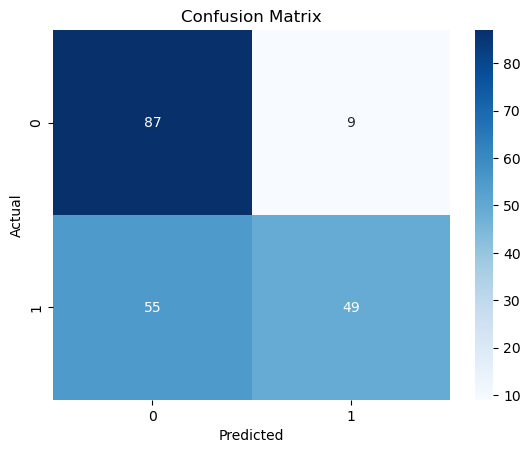

Accuracy: 68.00%
Precision: 0.73
Recall: 0.68
F1 Score: 0.67


In [ ]:
# Dự đoán trên tập kiểm tra
y_pred = knn.predict(X_test)
# Tính toán và hiển thị các chỉ số
accuracy, precision, recall, f1 = compute_metrics(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

In [17]:
# Hiển thị kết quả
import pandas as pd
pred_df = pd.DataFrame(y_pred, columns=['Predict'])
y_test_df = pd.DataFrame(y_test, columns=['Actual'])
result_df = pd.concat([pred_df.reset_index(drop=True), y_test_df.reset_index(drop=True)], axis=1)
print(result_df)

    Predict Actual
0       dog    dog
1       cat    dog
2       dog    dog
3       dog    dog
4       cat    cat
..      ...    ...
195     cat    cat
196     cat    cat
197     cat    cat
198     dog    dog
199     cat    cat

[200 rows x 2 columns]


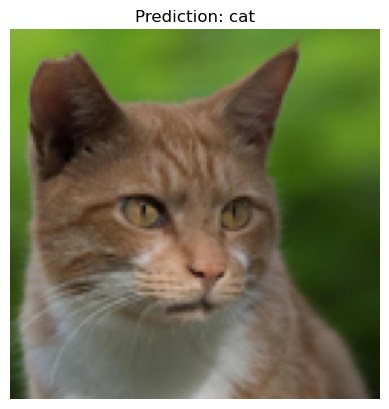

Prediction for image data/test/cat/flickr_cat_000253.jpg: cat


In [21]:
# Hàm dự đoán cho một ảnh đơn
def predict_single_image(image_path, knn, image_size=(128, 128)):
    try:
        img = Image.open(image_path)
        img_resized = img.resize(image_size)
        img_array = np.array(img_resized).flatten()
        img_array = img_array / 255.0  # Chuẩn hóa ảnh

        prediction = knn.predict([img_array])
        predicted_label = prediction[0]

        plt.imshow(img_resized)
        plt.title(f"Prediction: {predicted_label}")
        plt.axis('off')
        plt.show()

        print(f"Prediction for image {image_path}: {predicted_label}")
        return predicted_label
    except Exception as e:
        print(f"Error predicting image {image_path}: {e}")
        return None

# Đọc ảnh và dự đoán
image_path = "data/test/cat/flickr_cat_000253.jpg"  # Thay bằng đường dẫn ảnh của bạn
predicted_label = predict_single_image(image_path, knn)